In [1]:
# imports
from aerofoil2 import main_pontoon_calc
from aerofoil import calc_naca_area
from mech_module import *
from power_calcs import *


In [14]:
# define river speed and power requirements (the RPM is calculated from the river velocity)
foil_width = 1.8/4
river_vel = 1
turbine_width = 1.2
turbine_diameter = 1.2
pontoon_length = 1.8
r_drum = 0.425/2

# define debris defence
block_t = 0.005
block_w = 0.1
block_spacing = 0.2
grid_offset = 0.3


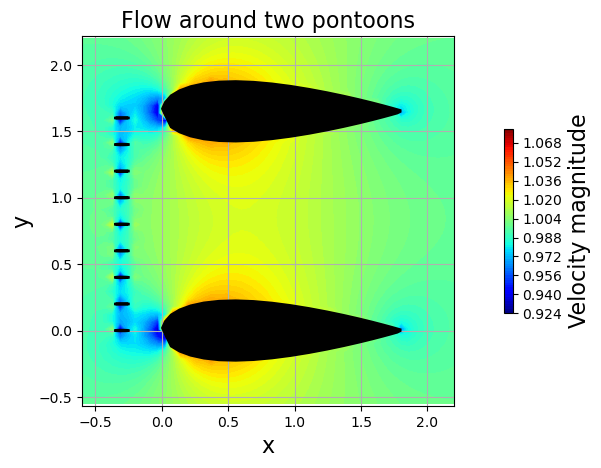

Average river velocity: 1.02 m/s


In [15]:
# apply effect of pontoons on river speed (calculate pontoon volume)
mean_pontoon_velocity = main_pontoon_calc(foil_width, turbine_width, pontoon_length,river_vel,grid=True, block_t = block_t, block_w=block_w, grid_offset=grid_offset, block_round=True, block_spacing=block_spacing, plot=True)
river_vel = mean_pontoon_velocity
print("Average river velocity: %.2f m/s" %river_vel)

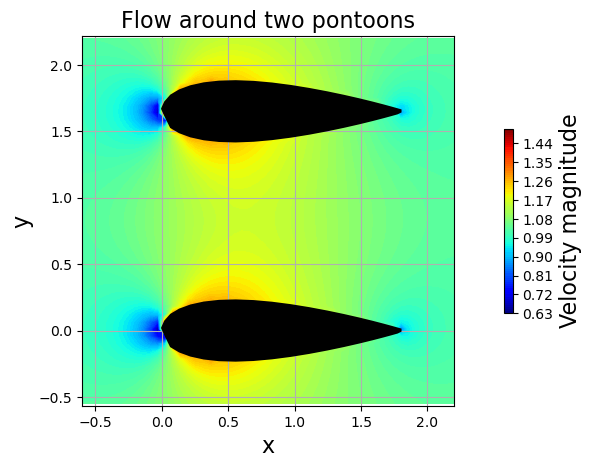

Average river velocity: 1.18 m/s


In [5]:
# apply effect of pontoons on river speed (calculate pontoon volume)
mean_pontoon_velocity = main_pontoon_calc(foil_width, turbine_width, pontoon_length,river_vel,grid=False, block_t = block_t, block_w=block_w, grid_offset=grid_offset, block_round=True, block_spacing=block_spacing, plot=True)
river_vel = mean_pontoon_velocity
print("Average river velocity: %.2f m/s" %river_vel)

In [6]:
# compare the effect of pontoon thickness and width on river speed
lengths = np.linspace(0.5, 2.5, 5)
widths = np.linspace(0.1, 0.6, 5)
river_vels = []
for l in lengths:
    for w in widths:
        river_vels.append(main_pontoon_calc(w, turbine_width, l, river_vel,grid=False, block_t = block_t, block_w=block_w, grid_offset=grid_offset, block_spacing=block_spacing, plot=False))

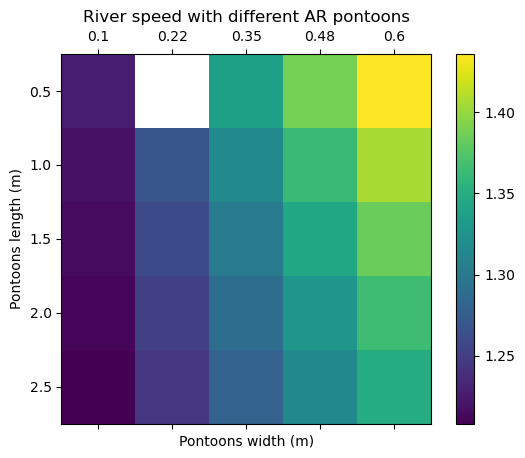

In [7]:
# plot results as a heatmap with 20 colours
river_vels_plot = np.array(river_vels).reshape(5,5)
fig, ax = plt.subplots()
cax = ax.matshow(river_vels_plot, cmap='viridis')
fig.colorbar(cax)
ax.set_xticklabels(['']+list(np.round(widths,2)))
ax.set_yticklabels(['']+list(np.round(lengths,2)))
ax.set_xlabel('Pontoons width (m)')
ax.set_ylabel('Pontoons length (m)')
ax.set_title('River speed with different AR pontoons')
plt.show()

In [8]:
# Prototype calculations - ignore
length = 0.36
pontoon_area = calc_naca_area(length/4,length)
print('Pontoons area = ', pontoon_area, 'm^2')
max_depth = 0.1
allowed_depth = max_depth - 0.045
prototype_mass = 2
pontoon_volume = prototype_mass / 1000
area = pontoon_volume / allowed_depth
print('Calcd Pontoons area = ', area, 'm^2')

print('Pontoon height = ', max_depth, 'm')
print('Pontoon width = ', length/4, 'm')
print('Pontoon length = ', length, 'm')



Pontoons area =  0.022176101403387563 m^2
Calcd Pontoons area =  0.03636363636363636 m^2
Pontoon height =  0.1 m
Pontoon width =  0.09 m
Pontoon length =  0.36 m


In [7]:
# calculate the area of the turbine
pontoon_area = calc_naca_area(foil_width, pontoon_length)

In [8]:
print('Pontoon area: ', pontoon_area)
print('Mean pontoon velocity: ', mean_pontoon_velocity)

Pontoon area:  0.5544025350846892
Mean pontoon velocity:  1.0236745060870358


In [9]:
# how tall do the pontoons need to be to support the turbine?
turbine_mass = 100
pontoon_height = pontoon_height_calc(pontoon_area, turbine_mass)
print('Pontoon height: ', pontoon_height)

Pontoon height:  0.09018717779196685


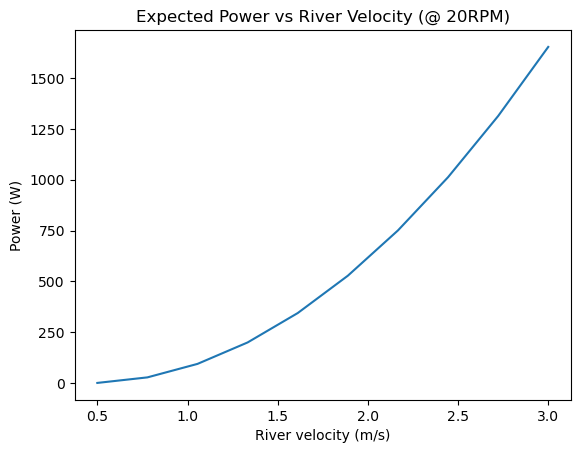

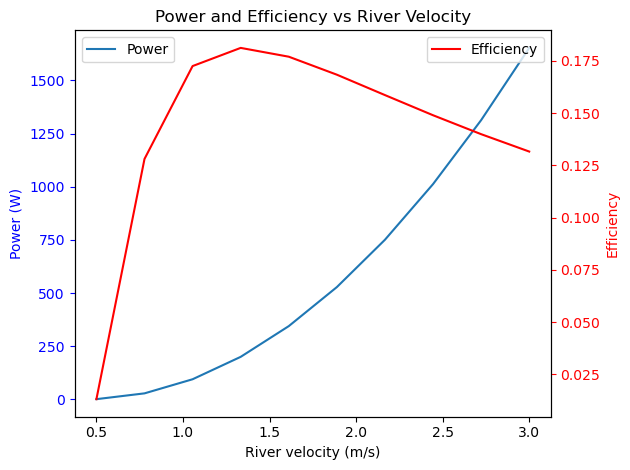

In [11]:
# calculate RPM (using the velocity model for shaft power output)
v = np.linspace(0.5,3,10)
p_array = power(v, runner_diameter=turbine_diameter, r_drum=r_drum, L=turbine_width/2, RPM=20)

max_power_array = []
# compare to the power of that flow to get the efficiency
blade_area = ((turbine_diameter/2) - r_drum) * turbine_width
for i in range(len(v)):
    p, _,_,_,_ = power_calc(efficiency=1,V=v[i],A=blade_area)
    max_power_array.append(p)

# overall efficiency
eff = p_array/max_power_array
efficiency = max(eff)

# plot power vs velocity 
plt.plot(v,p_array)
plt.xlabel('River velocity (m/s)')
plt.ylabel('Power (W)')
plt.title('Expected Power vs River Velocity (@ 20RPM)')
plt.show()


# plot power vs velocity and efficiency vs velocity on the same plot
fig, ax1 = plt.subplots()
ax1.plot(v,p_array, label='Power')
ax1.set_xlabel('River velocity (m/s)')
ax1.set_ylabel('Power (W)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_title('Power and Efficiency vs River Velocity')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(v,eff, label='Efficiency', color='r')
ax2.set_ylabel('Efficiency', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()





In [12]:
# with the RPM, power requirements, river velocity, and efficiency estimates for components
# calculate base dimensions for the turbine (width and radius of the turbine) (calculate rough volume of the turbine)

# set RPM to the max power RPM
RPM = 20

# estimate the efficiency of the turbine
generator_eff = 0.9
gearbox_eff = 0.95
drive_efficiency = generator_eff * gearbox_eff
print('Drive efficiency: ', drive_efficiency)

# hydro efficiency is calculated above as 0.12

# power required = 400w
power_required = 300
efficiency = efficiency * drive_efficiency
print('Overall Efficiency: ', efficiency)

# calculate the area required for the turbine
_, _, _, area, _ = power_calc(efficiency=efficiency,V=river_vel,P=power_required)
print('Area required (m^2): ', area)


Drive efficiency:  0.855
Overall Efficiency:  0.15498017004714387
Area required (m^2):  1.807006877765996


In [13]:
# using the above calculate the required blade thickness (with additional input of material properties)
# define the material properties
sigma_y = 23.5e6
worst_case_vel = 3
sf = 1.5
thickness = minimum_blade_thickness(sigma_y, worst_case_vel*sf, turbine_width/2, r_drum, rho=1000, RPM=RPM,CD = 1.28)
print('Blade thickness (mm): ', thickness)

Blade thickness (mm):  8.977943176322665


In [13]:
# run the debris impact model to determine worst case debris size and impact force
# define the material properties
impact_toughness = 2.6 # J/cm^2
size = debris_calc(impact_toughness, thickness, worst_case_vel)
print('Debris length size (mm): ', size)


Debris length size (mm):  347.6489338037143


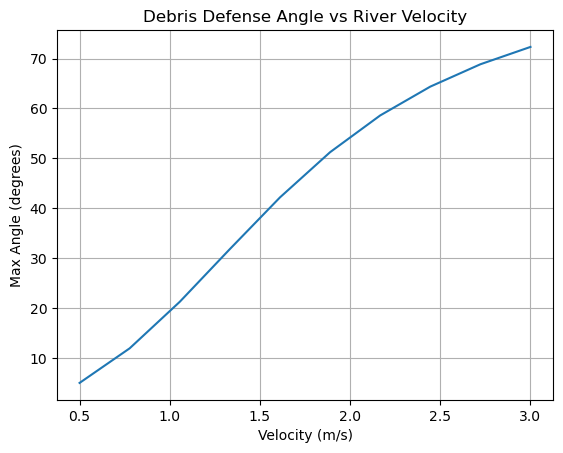

In [14]:
# calculate the angle of the debris defense system to send debris under the turbine
angles = []
velocities = np.linspace(0.5, 3,10 )
for u in velocities:
    angles.append(-debris_angle(u, size/1000 ))

# plot the angle vs velocity
plt.plot(velocities, angles)
plt.grid()
plt.xlabel('Velocity (m/s)')
plt.ylabel('Max Angle (degrees)')
plt.title('Debris Defense Angle vs River Velocity')
plt.show()


In [15]:
# using dimensions and inputs calculate the torque on the drive shaft

# calculate the torque on the drive shaft
torque_val = torque(worst_case_vel,turbine_diameter,r_drum, turbine_width/2,RPM)
print('Worst case torque (Nm): ', torque_val)

Worst case torque (Nm):  789.2017979492964
